In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy.stats import uniform
import itertools
from tqdm import tqdm
from functools import reduce
import matplotlib

In [57]:
sns.set(context="paper", style="ticks")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

TICKS_SIZE = 6
AXES_SIZE = 6.5
TINY_SIZE = 4
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=AXES_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=AXES_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICKS_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=TICKS_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=AXES_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.rc('axes', titlepad=1)
plt.rc('axes', labelpad=1)
plt.rc('lines', linewidth=0.5)
plt.rc('axes', linewidth=0.5)
plt.rc('xtick.major', width=0.25, size=1.5, pad=1)
plt.rc('xtick.minor', width=0.25, size=1.5, pad=1)
plt.rc('ytick.major', width=0.25, size=1.5, pad=1)
plt.rc('ytick.minor', width=0.25, size=1.5, pad=1)

# Gene expression - weight loss correlation matrix

## Read input files and open output files

### Weight loss matrix

In [2]:
df_weights_4 = pd.read_excel("inputs/weight_loss96.xlsx", index_col=0)

### Gene expression matrix

In [125]:
def read_gene_exp(gene_exp_path, drop_duplicates=False, transpose=True):
    gene_exp = pd.read_csv(gene_exp_path, index_col=0)
    # Remove genes with only zeros
    gene_exp = gene_exp[(gene_exp.T != 0).any()].transpose()
    # Drop duplicates
    if drop_duplicates:
        gene_exp = gene_exp.T[~gene_exp.T.index.duplicated(keep='first')].T
    # Apply log transformation on the remaining genes
    gene_exp = np.log(gene_exp + 0.000000000001)
    if transpose:
        gene_exp = gene_exp.T
    return gene_exp

In [126]:
time_points = [0, 3, 7, 24, 48, 96]
columns = None
exp_dfs_list = []

for t in time_points:
    cur_exp_df = read_gene_exp(f"inputs/gene_expression/gene_exp{t}.csv", drop_duplicates=True, transpose=False)
    cur_exp_df.index = cur_exp_df.index.map(lambda x: x.split(".")[0].split("_")[0])

    exp_dfs_list.append(cur_exp_df)
    if columns is None:
        columns = cur_exp_df.columns
    else:
        columns = columns.intersection(cur_exp_df.columns)

    print(f"{t} shape:", cur_exp_df.shape)

# Only check genes that were in all the data sets
exp_dfs = {}
for t, cur_exp_df in zip(time_points, exp_dfs_list):
    cur_exp_df = cur_exp_df[columns]
    exp_dfs[f"{t}_hours"] = pd.pivot_table(cur_exp_df, index=cur_exp_df.index)

(33948, 32)
0 shape: (32, 26841)
(27207, 31)
3 shape: (31, 26542)
(33948, 29)
7 shape: (29, 26470)
(33948, 32)
24 shape: (32, 26775)
(27150, 34)
48 shape: (34, 26495)
(27515, 38)
96 shape: (38, 26820)


## Calculate correlations

In [5]:
res = []
for x_name in exp_dfs:
    title = f"phenotype_4_days_exp_{x_name}"
    x_aligned, y_aligned = exp_dfs[x_name].align(df_weights_4, axis=0, join='inner')
    res.append(x_aligned.apply(lambda x: pd.Series(scipy.stats.pearsonr(x, y_aligned['weight_loss_96']), index=['r_%s' % title, 'p_value_%s' % title]), axis=0).T)

/Users/gal/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [6]:
weight_loss_cor = reduce(lambda left,right: pd.merge(left, right, how="inner", left_index=True, right_index=True), res)

In [7]:
weight_loss_cor.shape

(24486, 12)

In [8]:
weight_loss_cor.head()

,r_phenotype_4_days_exp_0_hours,p_value_phenotype_4_days_exp_0_hours,r_phenotype_4_days_exp_3_hours,p_value_phenotype_4_days_exp_3_hours,r_phenotype_4_days_exp_7_hours,p_value_phenotype_4_days_exp_7_hours,r_phenotype_4_days_exp_24_hours,p_value_phenotype_4_days_exp_24_hours,r_phenotype_4_days_exp_48_hours,p_value_phenotype_4_days_exp_48_hours,r_phenotype_4_days_exp_96_hours,p_value_phenotype_4_days_exp_96_hours
geneSymbol,,,,,,,,,,,,
0610005C13Rik,0.137580,0.460481,-0.305298,0.107294,-0.029496,0.881558,0.097173,0.603039,-0.218463,0.237724,0.078885,0.657431
0610007C21Rik,-0.259758,0.158187,0.006451,0.973507,-0.101547,0.607132,0.183896,0.322032,-0.141773,0.446792,-0.054048,0.761442
0610007L01Rik,-0.022330,0.905090,-0.039700,0.837987,0.286808,0.138942,-0.298036,0.103428,-0.284554,0.120783,0.073260,0.680522
0610007P08Rik,0.034104,0.855477,0.121865,0.528857,-0.242978,0.212810,0.186841,0.314205,-0.127007,0.495967,-0.005604,0.974905
0610007P14Rik,0.010178,0.956665,-0.391935,0.035487,-0.159453,0.417662,-0.082988,0.657160,-0.064614,0.729844,0.418969,0.013653


In [9]:
output_path = "outputs/gene_expression_weight_loss_corr_df.xlsx"
weight_loss_cor.to_excel(output_path)

# Gene expression - weight loss correlation matrix's clustering

In [10]:
weight_loss_cor = weight_loss_cor.filter(like="r_phenotype_4_days_exp")
weight_loss_cor.columns = [0, 3, 7, 24, 48, 96]
weight_loss_cor.head()

,0,3,7,24,48,96
geneSymbol,,,,,,
0610005C13Rik,0.137580,-0.305298,-0.029496,0.097173,-0.218463,0.078885
0610007C21Rik,-0.259758,0.006451,-0.101547,0.183896,-0.141773,-0.054048
0610007L01Rik,-0.022330,-0.039700,0.286808,-0.298036,-0.284554,0.073260
0610007P08Rik,0.034104,0.121865,-0.242978,0.186841,-0.127007,-0.005604
0610007P14Rik,0.010178,-0.391935,-0.159453,-0.082988,-0.064614,0.418969


In [11]:
weight_loss_cor.describe()

,0,3,7,24,48,96
count,24478.000000,24484.000000,24473.000000,24476.000000,24474.000000,24476.000000
mean,0.000915,-0.041115,0.013179,-0.023436,-0.009322,0.013438
std,0.185305,0.173947,0.177339,0.206948,0.191336,0.254464
min,-0.650378,-0.649089,-0.723816,-0.828499,-0.658394,-0.784072
25%,-0.132870,-0.165991,-0.115035,-0.176207,-0.145053,-0.164835
50%,-0.002610,-0.043271,0.019701,-0.022986,-0.006647,0.009789
75%,0.134105,0.081235,0.140709,0.130493,0.126799,0.184051
max,0.712777,0.620753,0.675703,0.689541,0.689118,0.787135


## Filtering out genes

In [12]:
weight_loss_cor = weight_loss_cor[~pd.isna(weight_loss_cor).any(axis=1)]

In [13]:
tresholds = weight_loss_cor.quantile([0.05, 0.95])
tresholds

,0,3,7,24,48,96
0.05,-0.300374,-0.318998,-0.282419,-0.361395,-0.323942,-0.396232
0.95,0.306082,0.243686,0.295389,0.313330,0.298580,0.451306


In [14]:
chosen_genes = weight_loss_cor.index[((weight_loss_cor < tresholds.loc[0.05]) | (weight_loss_cor > tresholds.loc[0.95])).any(axis=1)]
chosen_genes

Index(['0610007P14Rik', '0610007P22Rik', '0610008F07Rik', '0610009B14Rik',
       '0610009D07Rik', '0610009E02Rik', '0610011F06Rik', '0610031J06Rik',
       '0610037P05Rik', '0610039K10Rik',
       ...
       'n-R5s1', 'n-R5s102', 'n-R5s115', 'n-R5s122', 'n-R5s130', 'n-R5s136',
       'n-R5s46', 'snoU109', 'snoU6-53', 'snoU89'],
      dtype='object', name='geneSymbol', length=11117)

In [15]:
weight_loss_cor_10per = weight_loss_cor.loc[chosen_genes]

In [16]:
def check_direction_and_diff(x):
    x_len = x.shape[0]

    # Define a window around the max value for the current gene (x)
    x.index = range(x_len)
    max_pos = x.abs().idxmax()
    window = x[max(0, max_pos-1):min(x_len, max_pos+2)]

    # Check if any two values in the window have the same sign and are both larger than 0.15
    use_gene = ((np.sign(window).rolling(2).apply(lambda y: y.iloc[0] == y.iloc[1]).fillna(False).astype(bool)) &
                (window.rolling(2).apply(lambda x: (np.abs(x) > 0.15).all()))).any()

    return use_gene

In [17]:
chosen_genes = weight_loss_cor_10per.index[weight_loss_cor_10per.apply(check_direction_and_diff, axis=1)]
chosen_genes.shape

(5075,)

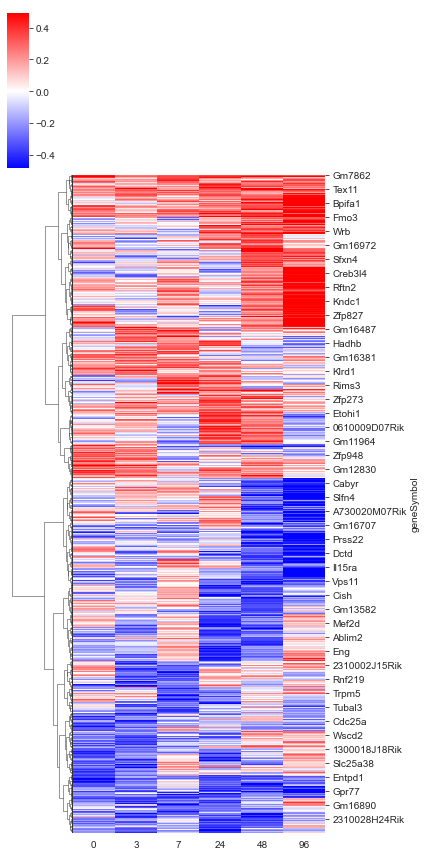

In [18]:
res = sns.clustermap(weight_loss_cor.loc[chosen_genes],
                     figsize=(6,12),
                     col_cluster=False,
                     method="ward",
                     center=0,
                     robust=True,
                     cmap = "bwr")

In [19]:
gene_order = chosen_genes[res.dendrogram_row.reordered_ind]

In [20]:
output_path = "outputs/gene_expression_weight_loss_corr_df_filtered.xlsx"
weight_loss_cor.loc[gene_order].to_excel(output_path)

# Within-cluster gene-gene correlations

## Read inputs and define relevant functions

In [21]:
time_points = [0, 7, 24, 48, 96]

In [22]:
unified_df = pd.read_excel("inputs/gene_expression_weight_loss_corr_df_filtered_clustered.xlsx", index_col=0)

In [23]:
unified_df.head()

,weight_cluster,weight_num,r_weight_96_exp_0,r_weight_96_exp_3,r_weight_96_exp_7,r_weight_96_exp_24,r_weight_96_exp_48,r_weight_96_exp_96
Cela3b,1,44,0.153594,0.226135,0.425616,0.265515,0.148212,0.293054
Cd164l2,1,302,0.173027,0.362678,0.554958,0.373151,0.349343,0.511039
Esrrg,1,250,0.225795,0.214819,0.132345,0.131580,0.351912,0.462074
AW551984,1,320,0.322147,0.297463,0.315270,0.410559,0.616262,0.563751
Mapk12,1,185,0.054484,0.240214,0.142040,0.233254,0.356273,0.518099


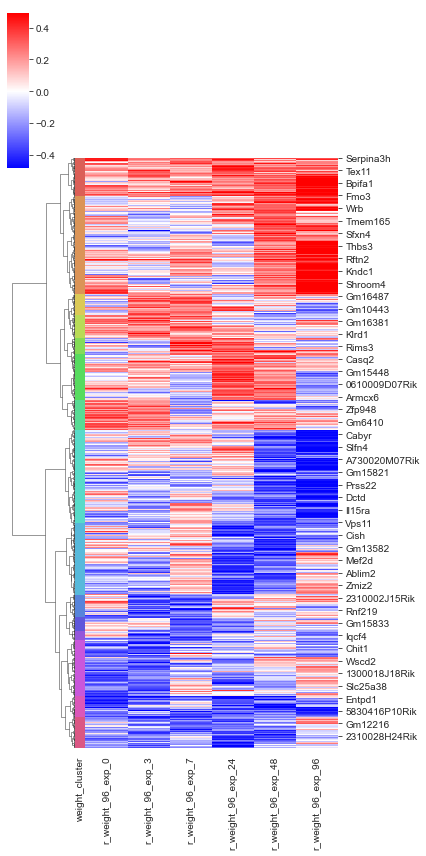

In [24]:
palette15 = itertools.cycle(sns.color_palette("hls", 15))
lut = dict(zip(range(1,16), palette15))
row_colors = unified_df["weight_cluster"].map(lut)

cg = sns.clustermap(unified_df.iloc[:, 2:],
                 figsize=(6,12),
                 col_cluster=False,
                 method="ward",
                 center=0,
                 row_colors=row_colors,
                 robust=True,
                 cmap = "bwr")

plt.savefig("outputs/gene_expression_weight_loss_corr_df_filtered_clustered.pdf",
            transparent=True, bbox_inches="tight")

In [25]:
gene_exp_list = [read_gene_exp(f"inputs/gene_expression/gene_exp{t}.csv", drop_duplicates=True) for t in time_points]

In [26]:
def shuffle_column(x):
    x_new = x.sample(frac=1)
    x_new.index = x.index
    return x_new


def calc_within_cluster_corr(df_full, time_df, cluster_num, cluster_field, perm=False):
    """
    Calculates the correlations between genes in a specific cluster
    :param df_full: A data frame with clustering information for each gene
    :param time_df: A data frame with gene expression at a certain time point
    :param cluster_num: An integer indicating the cluster we wish to correlate
    :param cluster_field: A string indicating the name of the cluster column in df_full
    :param perm: A boolean indicating whether to permute the data before calculating permutations,
    :return: in-cluster correlations data frame
    """
    weight_cluster_genes = df_full.query(f"{cluster_field} == {cluster_num}").index.unique()
    if perm:
        cluster_df = time_df.apply(shuffle_column, axis=1).reindex(weight_cluster_genes)
    else:
        cluster_df = time_df.reindex(weight_cluster_genes)
    cluster_df = cluster_df[~pd.isna(cluster_df).any(axis=1)]
    corr_df = pd.DataFrame(np.corrcoef(cluster_df), columns=cluster_df.index, index=cluster_df.index)
    return corr_df

## Calculate and plot the correlations

### Orig data (without permutations)

In [27]:
shared_index = gene_exp_list[0].index
for cur_exp_df in gene_exp_list[1:]:
    shared_index = shared_index.intersection(cur_exp_df.index)
print("shared_index shape:", shared_index.shape)
corr_df_dict = {}
for t, cur_gene_exp in zip(time_points, gene_exp_list):
    corr_df_dict[t] = {}
    for i in range(1, 16):
        corr_df_dict[t][i] = calc_within_cluster_corr(unified_df, cur_gene_exp.loc[shared_index], i, "weight_cluster")

shared_index shape: (24631,)


## Calculate the correlations between core genes of different clusters

### Functions

In [28]:
def choose_core_genes(cur_corr_df_dict, gene_num=30, quantile=0.75):
    gene_list = []
    for i in range(1, 16):
        corr_df = cur_corr_df_dict[i]
        gene_list += list(corr_df.quantile(quantile).nlargest(gene_num).index)
    return gene_list

In [29]:
def get_core_genes_exp_matrix(cur_gene_exp, cur_corr_df_dict, gene_num=30, quantile=0.75, df=unified_df):
    gene_list = choose_core_genes(cur_corr_df_dict, gene_num=gene_num, quantile=quantile)
    res_df = cur_gene_exp.loc[gene_list]
    res_df["cluster"] = df.loc[gene_list, "weight_cluster"]
    res_df.set_index("cluster", append=True, drop=True, inplace=True)
    return res_df

### Calculate and plot the correlations

In [75]:
res_df_list = [get_core_genes_exp_matrix(gene_exp_list[i], corr_df_dict[t], df=unified_df) for i, t in enumerate(time_points)]

### Calculate the mean expression of each core (in each time point)

In [31]:
res_df_mean_list = [res_df.groupby(level=1).mean().assign(time=t).set_index("time", append=True, drop=True) for res_df, t in zip(res_df_list, time_points)]
parameter_table = pd.concat(res_df_mean_list, sort=True)

In [32]:
core_genes_all_time_points = res_df_list[0].index
for res_df in res_df_list[1:]:
    core_genes_all_time_points = core_genes_all_time_points.union(res_df.index)
core_genes_all_time_points = core_genes_all_time_points.unique()

In [33]:
fig, axes = plt.subplots(nrows=15, ncols=5, figsize=(2, 4))
for i, (t, cluster_num) in enumerate(itertools.product(time_points, range(1, 16))):
    curr_df = corr_df_dict[t][cluster_num]
    # Cluster the heatmap
    Z = scipy.cluster.hierarchy.linkage(curr_df, method="ward", optimal_ordering=True)
    leaves_list = scipy.cluster.hierarchy.leaves_list(Z)
    curr_df_ordered = curr_df.iloc[leaves_list, leaves_list]

    # Plot
    ax = axes[(cluster_num-1) % 15, (time_points.index(t))]
    sns.heatmap(curr_df_ordered, cmap="bwr", vmin=-1, vmax=1,
                ax=ax, yticklabels=False, xticklabels=False,
                cbar=False, square=True)

plt.savefig("outputs/inter_cluster_correlations.png", dpi=600, transparent=True, bbox_inches="tight")
plt.close()

In [34]:
core_genes_all_time_points.shape

(1162,)

In [35]:
parameter_table.head()

,,1061A,111A,111B,1488A,1513A,188A,1912A,211B,2126A,2131A,...,5021A,5022A,5023A,57B,6009A,6012A,6018A,6020A,72A,B6
cluster,time,,,,,,,,,,,,,,,,,,,,,
1,0,NaN,2.032498,NaN,1.401456,NaN,1.443301,1.786317,1.849987,1.641028,NaN,...,1.658103,1.337163,1.491089,1.738172,1.696653,1.726595,2.233413,2.056103,1.361127,2.224821
2,0,NaN,2.421869,NaN,2.226548,NaN,2.546171,2.525580,2.599280,2.558189,NaN,...,2.208467,2.327059,2.310878,2.429053,2.336920,2.422485,2.611747,2.555888,2.384199,2.355071
3,0,NaN,-5.087577,NaN,-5.380300,NaN,-5.529247,-4.448257,-5.511634,-5.280342,NaN,...,-2.466512,-5.493727,-4.501756,-6.410843,-3.642464,-4.601724,-5.274682,-6.189929,-2.425703,-1.595735
4,0,NaN,-0.654126,NaN,-1.536342,NaN,-1.149017,-0.472630,0.087892,0.243620,NaN,...,1.399449,-0.837015,0.368062,0.163458,0.240051,-1.512749,-0.327914,0.548108,0.088618,1.180585
5,0,NaN,-2.283482,NaN,-3.370660,NaN,-5.892273,-3.137165,-4.127008,-5.809897,NaN,...,-3.992080,-3.332568,-1.335263,-3.969171,-2.332762,-4.213236,-2.074549,-0.942435,-4.819735,-2.926837


In [36]:
def cluster_param_feature(cur_gene_exp, parameter_table, lines_order,
                          df=unified_df, threshold=-1,
                          core_genes=None, corr_method="pearson",
                          plot=False, full=False, **kwargs):
    a = parameter_table[lines_order.index]
    if full:
        b = cur_gene_exp[lines_order.index]
    else:
        b = cur_gene_exp.loc[df.index, lines_order.index]

    param_feature_corr_list = []
    for feature in tqdm(b.iterrows()):
        param_feature_corr_list.append(a.corrwith(feature[1], axis=1, method=corr_method))
    param_feature_df = pd.concat(param_feature_corr_list, axis=1)
    param_feature_df.columns = b.index
    param_feature_df = param_feature_df[param_feature_df.columns[~pd.isna(param_feature_df).any()]]

    param_feature_df = param_feature_df[param_feature_df.abs().median(axis=1) > threshold]

    if plot and not full:
        if "time_points" in kwargs:
            time_points = kwargs["time_points"]
        else:
            time_points = [0, 7, 24, 48, 96]

        if "method" in kwargs:
            method = kwargs["method"]
        else:
            method = "average"

        if "metric" in kwargs:
            metric = kwargs["metric"]
        else:
            metric = "euclidean"

        if "col_colors_fields" in kwargs:
            col_colors_fields = kwargs["col_colors_fields"]
        else:
            col_colors_fields=["r_weight_96_exp_0",
                               "r_weight_96_exp_7",
                               "r_weight_96_exp_24",
                               "r_weight_96_exp_48",
                               "r_weight_96_exp_96"]


        palette5 = itertools.cycle(sns.color_palette("husl", 5))
        lut = dict(zip(time_points, palette5))
        time_colors = list(map(lambda x: lut[x], param_feature_df.index.get_level_values(1)))

        palette15 = itertools.cycle(sns.color_palette("hls", 15))
        lut2 = dict(zip(range(1,16), palette15))
        cluster_colors = list(map(lambda x: lut2[x], param_feature_df.index.get_level_values(0)))

        feature_cluster_colors = list(map(lambda x: lut2[x], df.loc[b.index, "weight_cluster"].drop_duplicates()))

        palette2 = itertools.cycle(sns.color_palette("Greys", 2))
        lut3 = dict(zip([True, False], palette2))
        core_colors = list(map(lambda x: lut3[x], param_feature_df.columns.map(lambda y: True if y in core_genes else False)))
        col_colors = [core_colors]

        for col in col_colors_fields:
            corr_range = [i/10.0 for i in range(-10, 11)]
            n = len(corr_range)
            palette = itertools.cycle(sns.color_palette("bwr", n))
            cur_lut = dict(zip(corr_range, palette))
            cur_weight_corr_colors = list(map(lambda x: cur_lut[x],
                                            df.loc[param_feature_df.columns, col].round(1)))
            col_colors.append(cur_weight_corr_colors)

        cg = sns.clustermap(param_feature_df, vmin=-1, vmax=1, cmap="bwr", yticklabels=True,
                            row_colors=[time_colors, cluster_colors], col_colors=col_colors,
                            figsize=(15,15), method=method, metric=metric)

        # Draw the legend bar for the classes
        for label in time_points:
            cg.ax_col_dendrogram.bar(0, 0, color=lut[label],
                                     label=label, linewidth=0)
        cg.ax_col_dendrogram.legend(loc="center", ncol=4)

        for label in range(1,16):
            cg.ax_col_dendrogram.bar(0, 0, color=lut2[label],
                                     label=label, linewidth=0)
        cg.ax_col_dendrogram.legend(loc="center", ncol=4)

        # Adjust the postion of the main colorbar for the heatmap
        cg.cax.set_position([.97, .2, .03, .45])

    return param_feature_df

In [37]:
lines_order = df_weights_4.loc[parameter_table.columns[~pd.isna(parameter_table).any()]].sort_values(by="weight_loss_96")

5075it [01:09, 72.74it/s]
5075it [01:08, 73.97it/s]
5075it [01:13, 69.11it/s]
5075it [01:12, 69.87it/s]


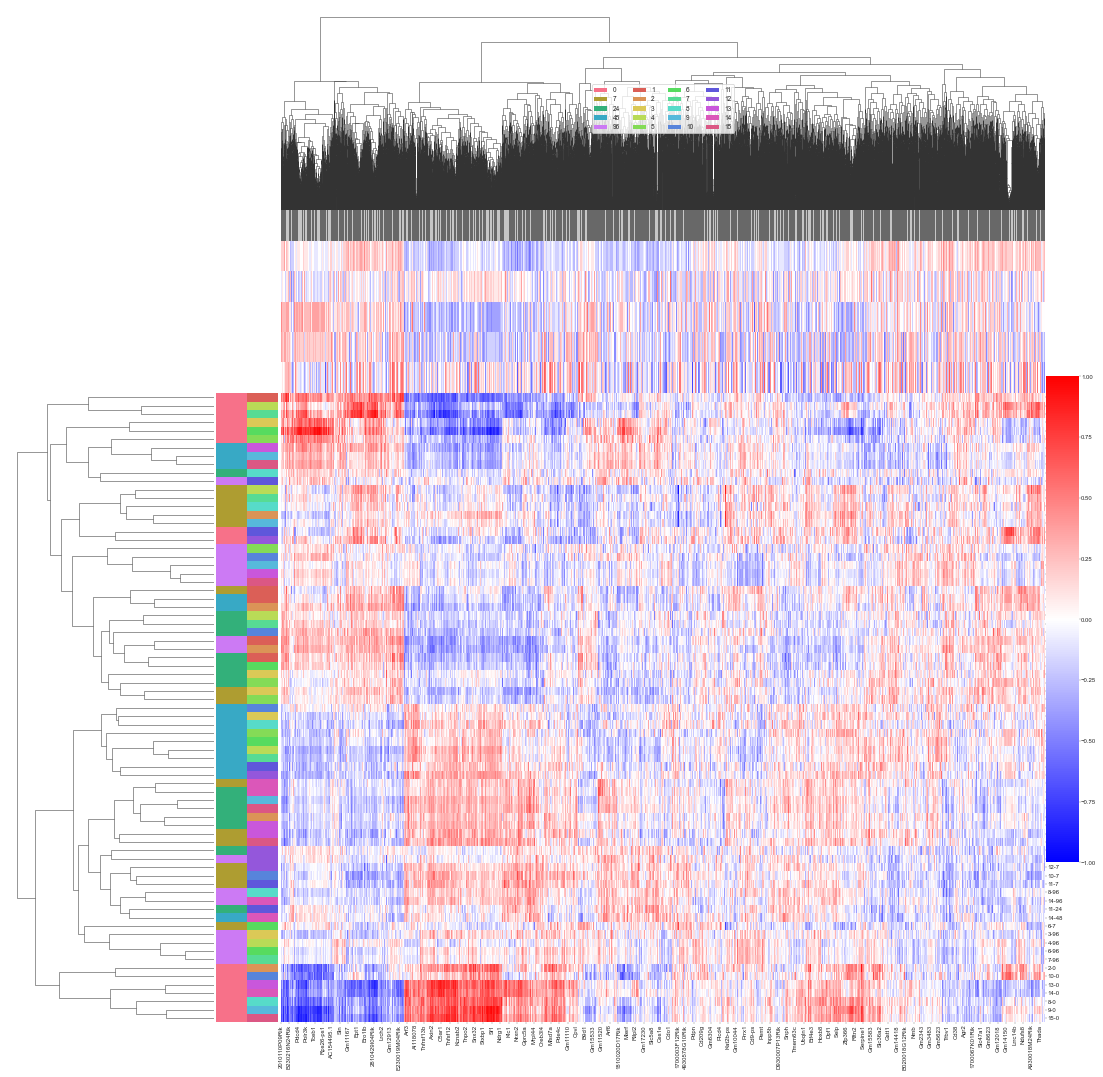

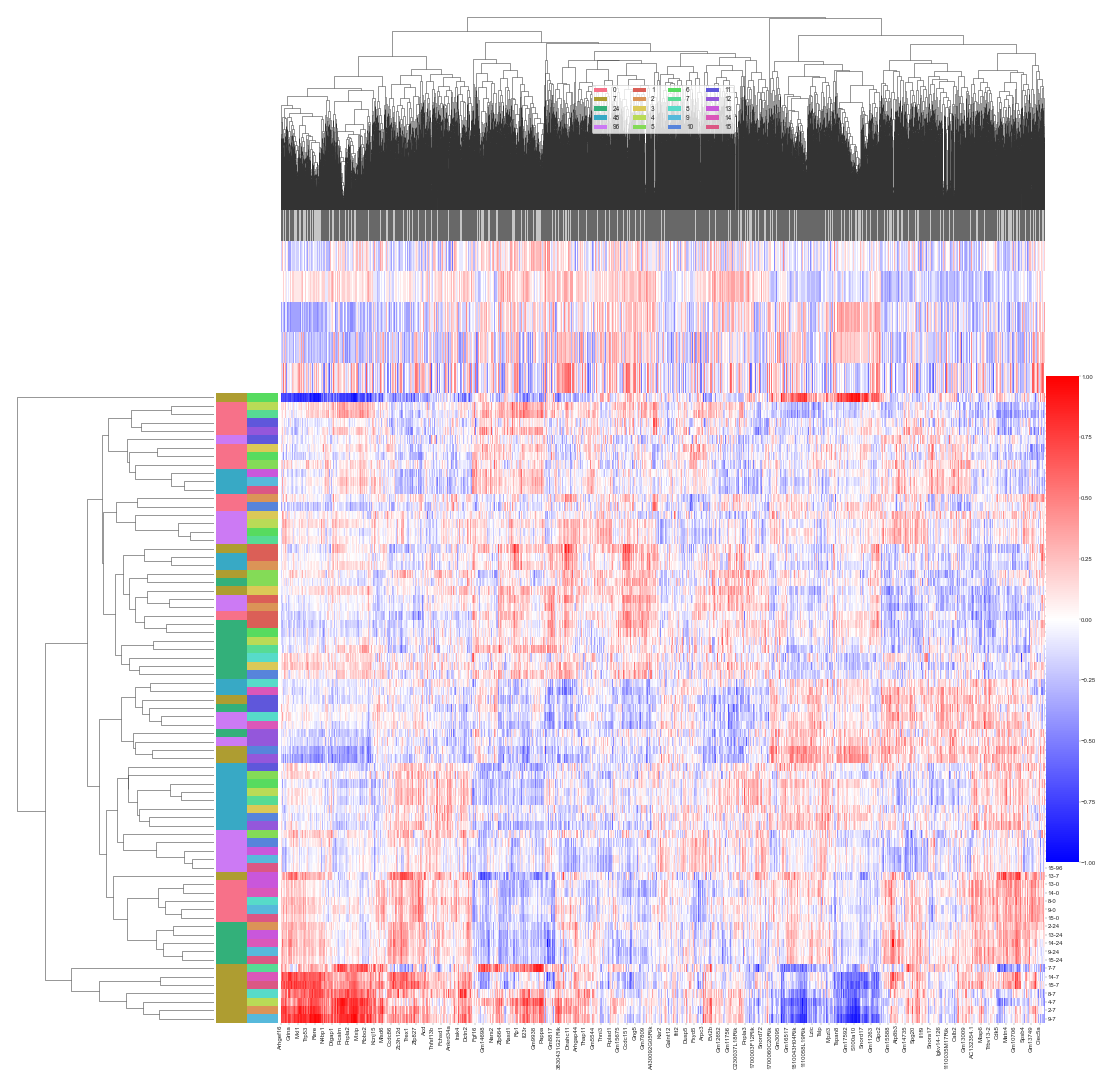

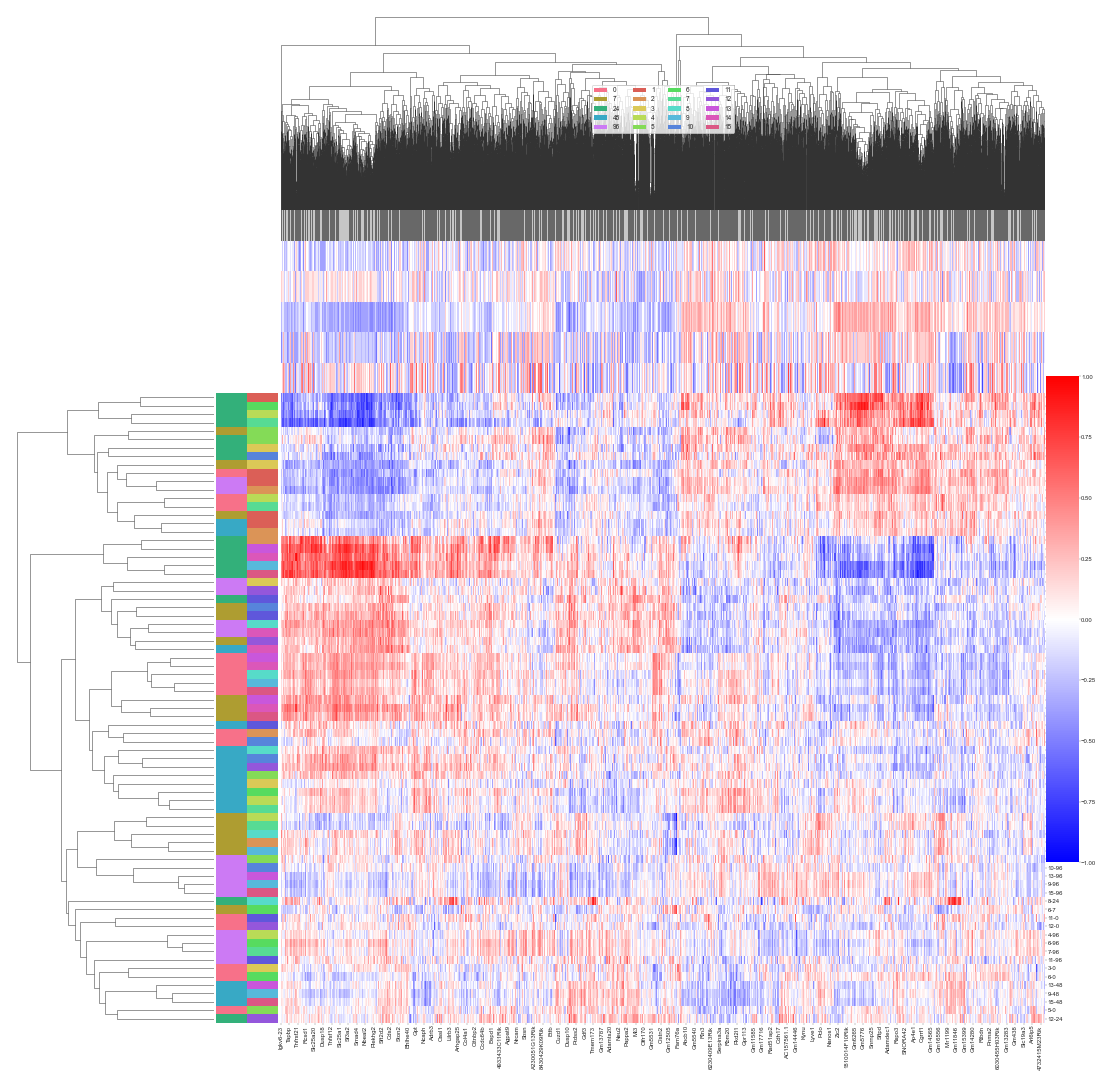

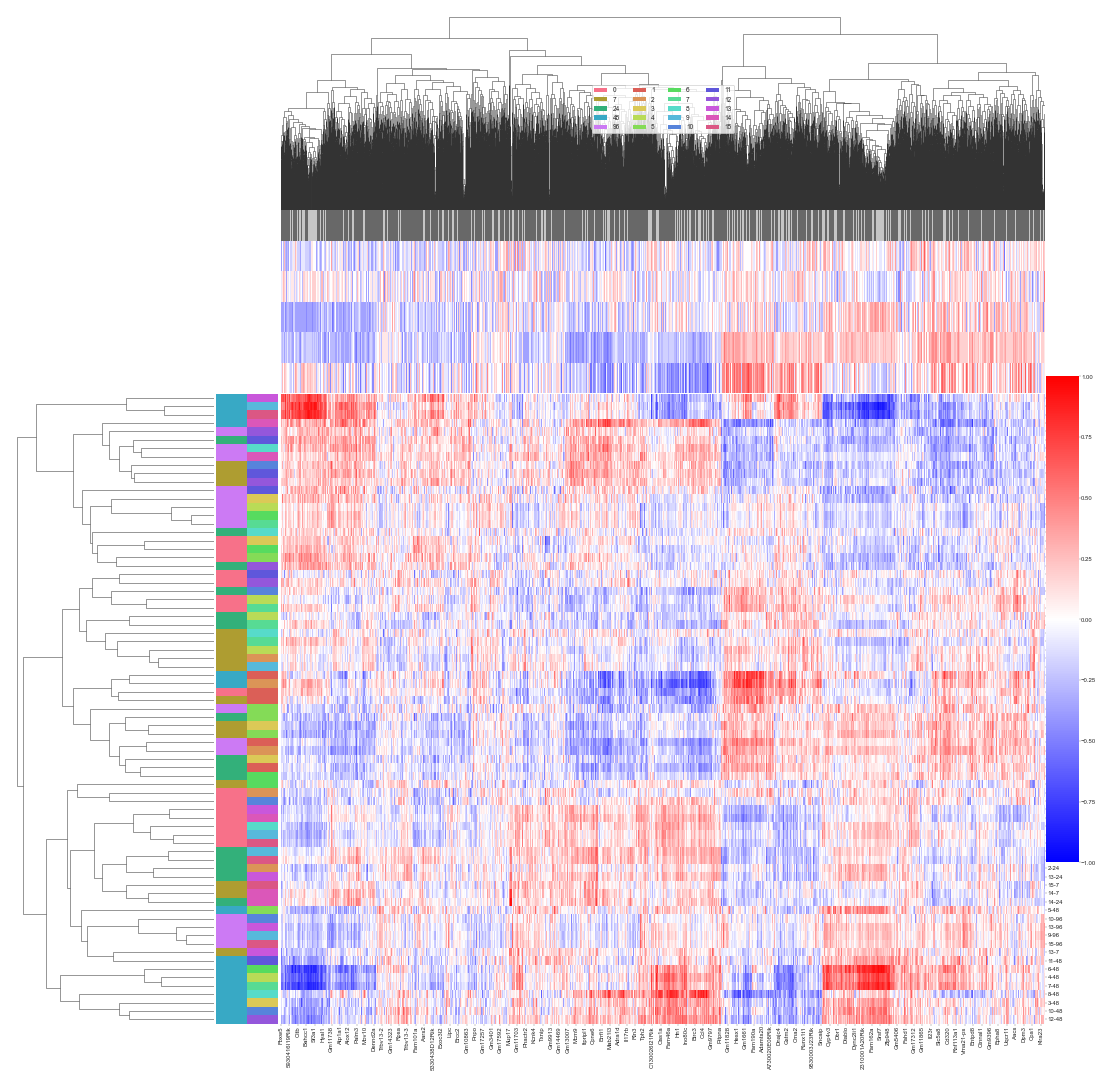

In [69]:
for t, cur_gene_exp in zip(time_points[:-1], gene_exp_list[:-1]):
    cur_param_feature_df = cluster_param_feature(cur_gene_exp, parameter_table, lines_order,
                                               df=unified_df,core_genes=core_genes_all_time_points, plot=True)

    plt.savefig(f"outputs/param_feature_df{t}.pdf", transparent=True, bbox_inches="tight")

5075it [01:07, 75.57it/s]


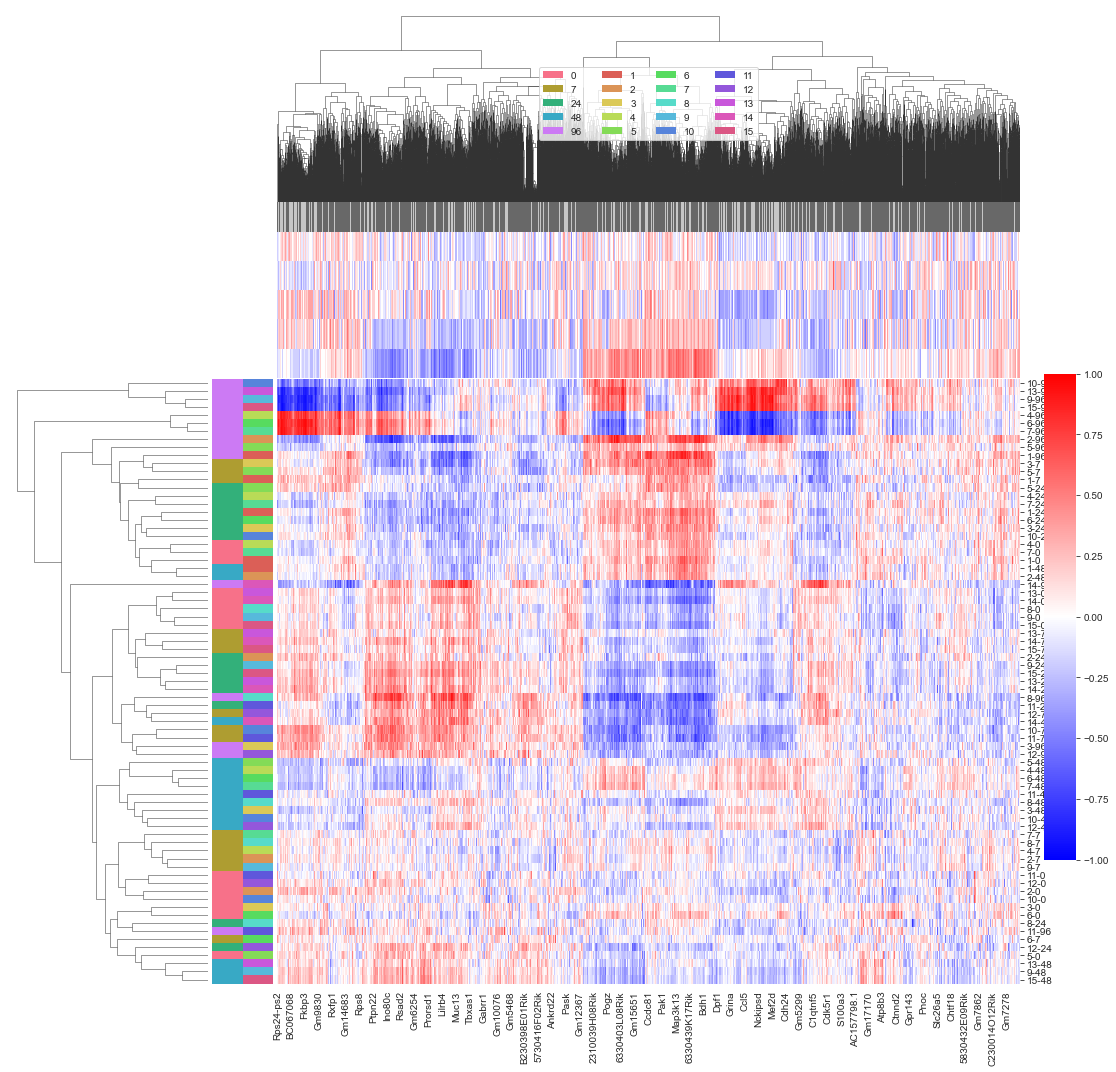

In [38]:
param_feature_df96 = cluster_param_feature(gene_exp_list[-1], parameter_table, lines_order,
                                          df=unified_df,core_genes=core_genes_all_time_points, plot=True)

plt.savefig("outputs/param_feature_df96.pdf", transparent=True, bbox_inches="tight")

In [39]:
param_feature_df96_full = cluster_param_feature(gene_exp_list[-1], parameter_table, lines_order, full=True)

26820it [05:46, 77.31it/s]


In [40]:
output_path = "outputs/param_feature_df96.xlsx"
param_feature_df96.to_excel(output_path)

In [41]:
output_path_full = "outputs/param_feature_df96_full.csv"
param_feature_df96_full.to_csv(output_path_full)

# Dimension reduction

In [42]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense
from keras.models import Model, model_from_json

In [43]:
input_df = param_feature_df96
if input_df.shape[0] < input_df.shape[1]:
    input_df = input_df.T

scaler = MinMaxScaler()
scaler.fit(input_df)
X = scaler.transform(input_df)

activation = "sigmoid"

input_dim = X.shape[1]
encoding_dim = 2
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation=activation)(input_img)
decoded = Dense(input_dim, activation=activation)(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X, X,
                          epochs=50,
                          batch_size=16,
                          shuffle=True,
                          validation_split=0.1,
                          verbose = 0)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
encoded_data = encoder.predict(X)

input_res = pd.DataFrame(encoded_data, index=input_df.index, columns=["comp1", "comp2"])

## The following part is based on the code from here: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# serialize model to JSON
model_json = encoder.to_json()
with open("outputs/encoder_model.json", "w") as json_file: #TODO: change the paths that have dates on to the ones we originally ysed
    json_file.write(model_json)
# serialize weights to HDF5
encoder.save_weights("outputs/encoder_model.h5")
print("Saved model to disk")

/Users/gal/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/gal/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
2022-08-07 13:13:40.755129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


159/159 [==============================] - 0s 524us/step
Saved model to disk


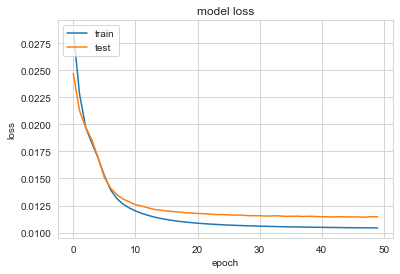

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Casting the remaining genes onto the gene map

In [45]:
param_feature_df96_full = pd.read_csv("outputs/param_feature_df96_full.csv",
                                      index_col=0).T
param_feature_df96_full = param_feature_df96_full.drop("time", axis=0)

In [46]:
param_feature_df96_full.head()

cluster,1,2,3,4,5,6,7,8,9,10,...,6,7,8,9,10,11,12,13,14,15
Gnai3,-0.064261,0.376051,0.009762,-0.025540,0.082808,-0.224324,-0.143304,0.198082,0.190627,0.145921,...,0.913856,0.944989,0.237574,-0.879084,-0.666255,0.028020,0.139329,-0.904191,-0.295675,-0.902747
Cdc45,-0.324907,0.182442,-0.183826,-0.218356,-0.007393,-0.287442,-0.231313,0.468626,0.312541,0.133860,...,0.450243,0.361632,0.189712,-0.365710,-0.030805,-0.052177,0.308805,-0.300985,0.068918,-0.310624
H19,0.154977,-0.388616,0.196756,0.069614,0.233327,0.170939,0.152056,-0.232574,-0.193937,-0.373499,...,-0.481851,-0.381038,-0.146606,0.469267,0.067391,-0.244318,-0.299270,0.381291,0.074212,0.418141
Scml2,0.079926,0.311738,-0.007580,-0.132932,-0.219570,-0.172227,-0.199908,0.134024,0.061870,-0.033352,...,0.585396,0.605021,-0.230058,-0.564976,-0.270182,0.006042,0.005898,-0.442618,-0.534842,-0.552281
Apoh,-0.372086,-0.107668,0.271569,0.070649,0.067151,0.046239,0.161093,0.149450,0.086820,-0.256955,...,0.133378,0.115670,0.226365,-0.191961,-0.159251,0.029464,0.019652,-0.217919,0.252429,-0.160644


In [47]:
# load json and create model - using the original weights
json_file = open('inputs/encoder_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
encoder = model_from_json(loaded_model_json)
# load weights into new model
encoder.load_weights("inputs/encoder_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [48]:
X2 = scaler.transform(param_feature_df96_full)
encoded_data_full = encoder.predict(X2)

830/830 [==============================] - 0s 499us/step


In [49]:
param_feature_df96_full_res = pd.DataFrame(encoded_data_full, index=param_feature_df96_full.index, columns=["comp1", "comp2"])

In [50]:
param_feature_df96_full_res.head()

,comp1,comp2
Gnai3,0.318572,0.112684
Cdc45,0.689717,0.236563
H19,0.526025,0.749368
Scml2,0.204956,0.294805
Apoh,0.706068,0.270699


In [51]:
output_path = "outputs/param_feature_df96_full_res.xlsx"
param_feature_df96_full_res.to_excel(output_path)

# Rotate gene map

In [52]:
def rotate_space(gene_space, angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    comp1 = gene_space.apply(lambda x: np.linalg.solve(R, x)[0], axis=1)
    comp2 = gene_space.apply(lambda x: np.linalg.solve(R, x)[1], axis=1)
    df_res = pd.concat([comp1, comp2], axis=1)
    df_res.columns = ["comp1", "comp2"]
    df_res = df_res - df_res.median()
    return df_res

gene_map = rotate_space(param_feature_df96_full_res, 360 - 45)
gene_map.columns = ["R", "T"]

In [53]:
gene_map.to_excel("outputs/gene_map.xlsx")

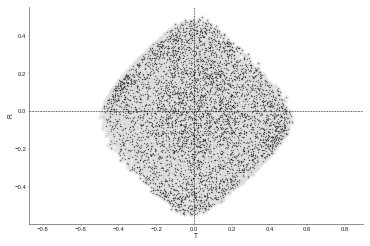

In [67]:
fig, ax = plt.subplots()
sns.scatterplot(data=gene_map, x="T", y="R",
                color="lightgrey", alpha=0.5,
                ax=ax)
sns.scatterplot(data=gene_map.loc[param_feature_df96.columns], x="T", y="R",
                color="black", alpha=0.5, s=2,
                ax=ax)
ax.axis('equal')
ax.axvline(0, ls="--", color="black")
ax.axhline(0, ls="--", color="black")
sns.despine()
plt.savefig("outputs/gene_map.pdf", transparent=True, bbox_inches="tight")